In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


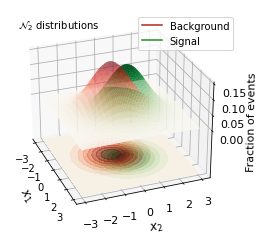

In [3]:
# PLOT 2 MULTIVARIATE GAUSSIAN DISTRIBUTIONS

# Our 2-dimensional distribution will be over variables X and Y
N = 80
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0.3, 0.3])
mu2 = np.array([-0.3, -0.3])
Sigma = np.array([[ 1. , 0], [0,  1]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)
Z2 = multivariate_gaussian(pos, mu2, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')

z_aux = np.linspace(2, 2, 2)
x_aux = z_aux
y_aux = z_aux

ax.plot(x_aux, y_aux, z_aux, color='firebrick', label='Background')
ax.plot(x_aux, y_aux, z_aux, color='forestgreen', label='Signal')
ax.legend(loc={0.6,0.8})

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=1, antialiased=True,
                cmap=cm.Greens)
ax.plot_surface(X, Y, Z2, rstride=3, cstride=3, linewidth=1, antialiased=True,alpha=0.4,
                cmap=cm.Reds)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.Greens)
cset2 = ax.contourf(X, Y, Z2, zdir='z', offset=-0.15, cmap=cm.Reds,alpha=0.5)

# Adjust the limits, ticks and view angle
ax.set_facecolor("white")
ax.set_zlim(-0.15,0.15)
ax.set_zticks(np.linspace(0,0.15,4))
ax.view_init(27, -21)
plt.xlabel("$x_1$",fontsize=12)
plt.ylabel("$x_2$",fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
ax.zaxis.set_tick_params(labelsize=11)

ax.text2D(0.05, 0.9, "$\mathcal{N}_{2}$ distributions", transform=ax.transAxes)
ax.text2D(1.1, 0.25, "Fraction of events", transform=ax.transAxes, rotation=89, fontsize=11)
plt.savefig('images/' + '2gaussian-distributions.pdf', format="pdf", bbox_inches="tight")
plt.show()

### Gaussians

In [4]:
##############
# PARAMETERS #
##############

# gaussian, mean
epsilon = 0.3

# number of events
N = 1000000

# requested number of ensembles
n_ensembles = 10000

# number of expected background events per ensemble
B_expected = 50000

# ratio S_expected/B_expected (signal ratio)
SB_ratio = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075]





# SOME USEFUL DERIVATED PARAMETERS:

# S_expected:
S_expected = [ int(SB_ratio[iii]*B_expected) for iii in range(len(SB_ratio)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(SB_ratio)) ]

(1000000, 2)
(1000000, 1)
(1000000, 2)
(1000000, 1)


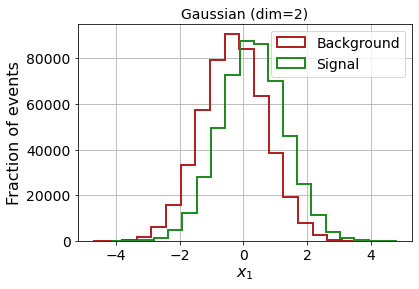

In [5]:
#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=2)",fontsize=14)
plt.show()  

### XGBoost (per-event)

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67919	validation_1-logloss:0.67926
[1]	validation_0-logloss:0.66768	validation_1-logloss:0.66781
[2]	validation_0-logloss:0.65825	validation_1-logloss:0.65843
[3]	validation_0-logloss:0.65040	validation_1-logloss:0.65064
[4]	validation_0-logloss:0.64389	validation_1-logloss:0.64416
[5]	validation_0-logloss:0.63847	validation_1-logloss:0.63878
[6]	validation_0-logloss:0.63391	validation_1-logloss:0.63424
[7]	validation_0-logloss:0.63013	validation_1-logloss:0.63048
[8]	validation_0-logloss:0.62693	validation_1-logloss:0.62732
[9]	validation_0-logloss:0.62426	validation_1-logloss:0.62469
[10]	validation_0-logloss:0.62203	validation_1-logloss:0.62248
[11]	validation_0-logloss:0.62012	validation_1-logloss:0.62059
[12]	validation_0-logloss:0.61852	validation_1-logloss:0.61902
[13]	validation_0-logloss:0.61720	validation_1-logloss:0.61772
[14]	validation_0-logloss:0.61606	validation_1-logloss:0.61660
[15]	validation_0-logloss:0.61513	validation_1-logloss:0.61569
[1

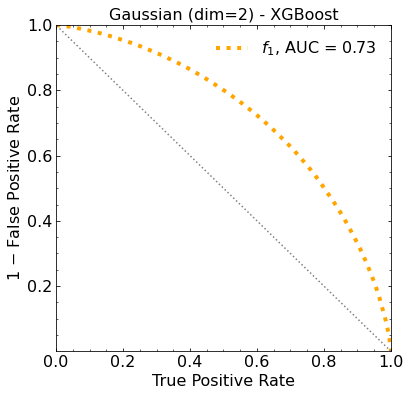

In [6]:
# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=2) - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

Classification score:


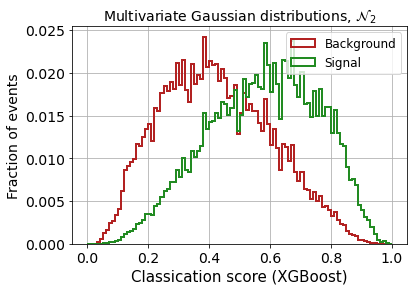

In [7]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


# print('Classification score interpolation:')
# # x to plot
# xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
# xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

# plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
# plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel("Network output",fontsize=16)
# plt.ylabel("Fraction of events",fontsize=16)
# plt.grid()
# plt.legend(fontsize=14)
# plt.show()

<ipython-input-8-9b2ac73a5883>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


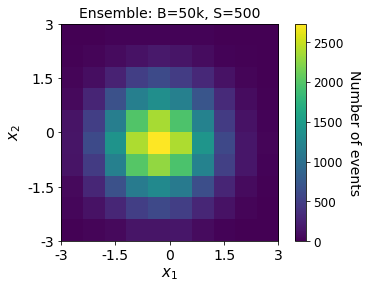

In [8]:
# Plot 1 ensemble with B=50k events and S=500 events

hist, xbins, ybins = np.histogram2d(np.concatenate([X_gauss_val_SM[:50000],X_gauss_val_NP[:500]])[:,1], np.concatenate([X_gauss_val_SM[:50000],X_gauss_val_NP[:500]])[:,0], bins=(10, 10), range = [[-3,3],[-3,3]])

im = plt.imshow(hist,interpolation='none')
plt.gca().invert_yaxis() 
cbar = plt.colorbar()
cbar.ax.set_ylabel('Number of events', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 17
cbar.ax.tick_params(labelsize=12)

ax = plt.subplot(111)
bins_labelsx = [-0.5,2,4.5,7,9.5]
namesx = ['-3','-1.5','0','1.5','3']
ax.set_xticks(bins_labelsx)
ax.set_xticklabels(namesx)
bins_labelsy = [-0.5,2,4.5,7,9.5]
namesy = ['-3','-1.5','0','1.5','3']
ax.set_yticks(bins_labelsy)
ax.set_yticklabels(namesy)
plt.xlabel('$x_1$',fontsize=15)
plt.ylabel('$x_2$',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Ensemble: B=50k, S=500', fontsize=14)
plt.savefig('images/' + '2gaussian-ensemble-example.pdf', format="pdf", bbox_inches="tight")
plt.show()

## METHODS

### 1. BINNED POISSON LOG-LIKELIHOOD

In [9]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################


store_Z_bins = []


for iii in range(len(SB_ratio)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])

    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(N / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(N / S_expected[iii])
    N_events_sig = N_ensembles_sig * S_expected[iii]


    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([background_X_1[:N_events_back],background_X_2[:N_events_back]], bins=(10,10), range = [[-3,3],[-3,3]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([signal_X_1[:N_events_sig],signal_X_2[:N_events_sig]], bins=(10,10), range = [[-3,3],[-3,3]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins = ( 2* sum( ( (sig_prom + back_prom) * np.log( 1 + (sig_prom/back_prom) ) ) - sig_prom ) )**0.5

    store_Z_bins.append(Z_bins)

    print('Z_bins : ', Z_bins)
    
    print('\n ----------------------------------- \n')


B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
Z_bins :  0.3112537720823787

 ----------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
Z_bins :  0.777443201794354

 ----------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
Z_bins :  1.5526056891636315

 ----------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
Z_bins :  2.325538775525865

 ----------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
Z_bins :  3.096256613563857

 ----------------------------------- 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
Z_bins :  7.676530858748111

 ----------------------------------- 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
Z_bins :  15.156489469733547

 ----------------------------------- 

B_expected:  50000
S_expected:  

In [10]:
print(store_Z_bins)

[0.3112537720823787, 0.777443201794354, 1.5526056891636315, 2.325538775525865, 3.096256613563857, 7.676530858748111, 15.156489469733547, 22.466335869826572]


In [9]:
# To use if you dont want to run everything again. Its the previous results
store_Z_bins = [0.3112537720823787, 0.777443201794354, 1.5526056891636315, 2.325538775525865, 3.096256613563857, 7.676530858748111, 15.156489469733547, 22.466335869826572]

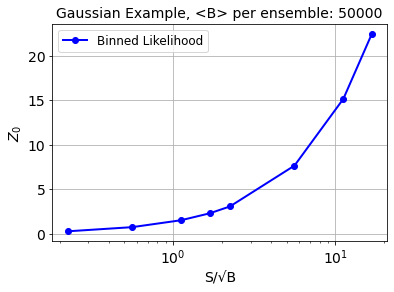

In [10]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins, '-ok', color='blue', lw=lw, label='Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{0}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### 2. TRUE PDF LIKELIHOOD (GAUSSIANS)

B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
n_ensembles (initial):  10000

 If  10010  =  1005    then the proposed range has to be extended
n_ensembles (actual):  9232
This may take long...


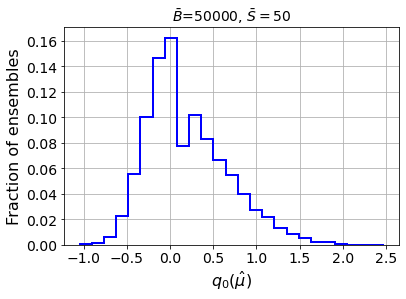

muhat mean:  0.8245883882149047
median q_muhat:  0.08410606173127633
Z_gaussian:  0.29001045107250245

 ------------------------------------ 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
n_ensembles (initial):  10000

 If  10025  =  1006    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


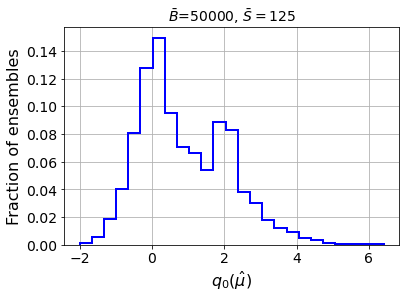

muhat mean:  0.9328387306400953
median q_muhat:  0.5991016152309214
Z_gaussian:  0.7740165471299185

 ------------------------------------ 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
n_ensembles (initial):  10000

 If  10050  =  1007    then the proposed range has to be extended
n_ensembles (actual):  9234
This may take long...


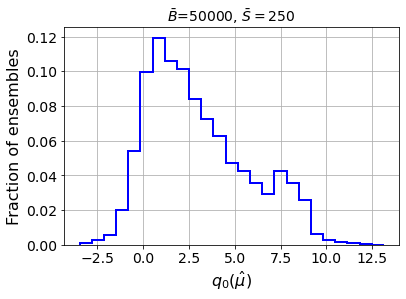

muhat mean:  1.018810916179337
median q_muhat:  2.4509457581497713
Z_gaussian:  1.5655496664589634

 ------------------------------------ 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
n_ensembles (initial):  10000

 If  10075  =  1007    then the proposed range has to be extended
n_ensembles (actual):  9234
This may take long...


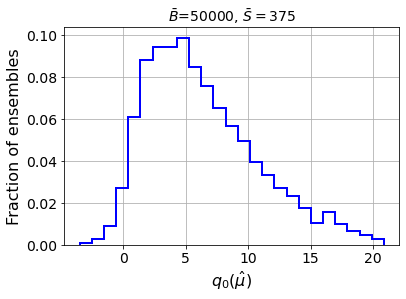

muhat mean:  1.0391812865497074
median q_muhat:  5.517123657423042
Z_gaussian:  2.3488558187813577

 ------------------------------------ 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


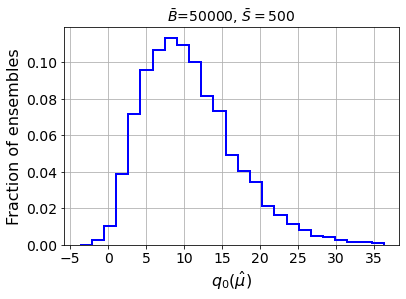

muhat mean:  1.0417632405502002
median q_muhat:  9.960802893847472
Z_gaussian:  3.156073968373915

 ------------------------------------ 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
n_ensembles (initial):  10000

 If  10250  =  1015    then the proposed range has to be extended
n_ensembles (actual):  9242
This may take long...


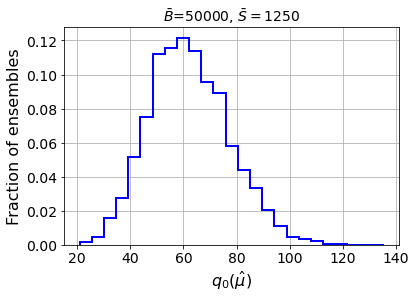

muhat mean:  1.0419065137416141
median q_muhat:  61.38027310531356
Z_gaussian:  7.8345563438725465

 ------------------------------------ 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
n_ensembles (initial):  10000

 If  10500  =  1025    then the proposed range has to be extended
n_ensembles (actual):  9238
This may take long...


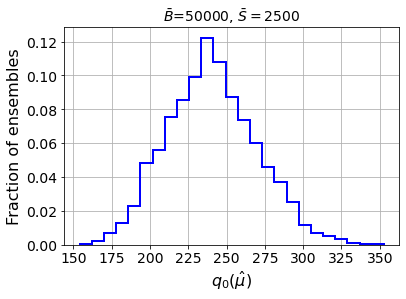

muhat mean:  1.0445442736523056
median q_muhat:  239.53316806782368
Z_gaussian:  15.476859115073177

 ------------------------------------ 

B_expected:  50000
S_expected:  3750
S/$\sqrt{B}$:  16.77050983124842
n_ensembles (initial):  10000

 If  10750  =  1034    then the proposed range has to be extended
n_ensembles (actual):  9234
This may take long...


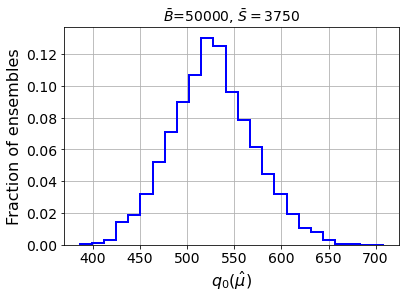

muhat mean:  1.0456681828026857
median q_muhat:  526.0286484123972
Z_gaussian:  22.935314438925776

 ------------------------------------ 



In [12]:
store_muhat_mean_gaussian = []
store_Z_gaussian = []

for iii in range(len(SB_ratio)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print('S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    
    print('This may take long...')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################
    muhat_selected_list = []
    q_muhat = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

            # SIGNAL events in an ensemble
            NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

            prob_NP_given_B = [] # p_b(S_ensemble)
            prob_NP_given_S = [] # p_s(S_ensemble)

            for ll in range(len(NP_shuf)):
                prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 ) ) )
                prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 ) ) )


            # BACKGROUND events in an ensemble
            SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

            prob_SM_given_B = [] # p_b(B_ensemble)
            prob_SM_given_S = [] # p_s(B_ensemble)

            for ll in range(len(SM_shuf)):
                prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 ) ) )
                prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 ) ) )


            # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
            prob_x_given_B = prob_SM_given_B + prob_NP_given_B

            # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
            prob_x_given_S = prob_SM_given_S + prob_NP_given_S




            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble



            mu_hat_condition_equal_1 = []

            # grid, mu_hat is around 1
            muhat_test = np.arange(0.5, 2, 0.1).tolist()

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



            muhat_selected = 1

            # from the grid, select the mu_hat such that the condition is equal to 1
            if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 > 0:
                        muhat_selected = muhat_test[ll]
                        break


            if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 < 0:
                        muhat_selected = muhat_test[ll]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



    # Histogram of q_muhats

    weights = np.ones_like(q_muhat)/float(len(q_muhat))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean = np.mean(muhat_selected_list)
    store_muhat_mean_gaussian.append(muhat_mean)

    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]
    
    q_muhat_median = np.median(q_muhat)

    Z_gaussian = abs(q_muhat_median)**0.5
    store_Z_gaussian.append(Z_gaussian)

    print('muhat mean: ', muhat_mean)
    print('median q_muhat: ', q_muhat_median)
    print('Z_gaussian: ', Z_gaussian)


    print('\n ------------------------------------ \n')


In [23]:
print(store_muhat_mean_gaussian)
print(store_Z_gaussian)

[0.8245883882149047, 0.9328387306400953, 1.018810916179337, 1.0391812865497074, 1.0417632405502002, 1.0419065137416141, 1.0445442736523056, 1.0456681828026857]
[0.45474917481666804, 0.9535537649177378, 1.7298816033011188, 2.5322195491684343, 3.3309765823407793, 8.041547504350502, 15.650232948815258, 23.122188122622383]


In [11]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_gaussian = [0.8245883882149047, 0.9328387306400953, 1.018810916179337, 1.0391812865497074, 1.0417632405502002, 1.0419065137416141, 1.0445442736523056, 1.0456681828026857]
store_Z_gaussian = [0.45474917481666804, 0.9535537649177378, 1.7298816033011188, 2.5322195491684343, 3.3309765823407793, 8.041547504350502, 15.650232948815258, 23.122188122622383]

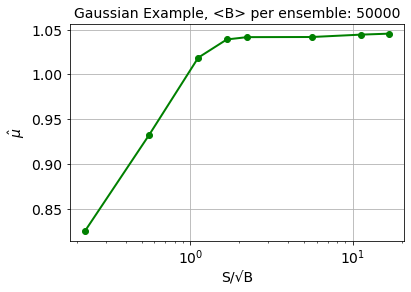

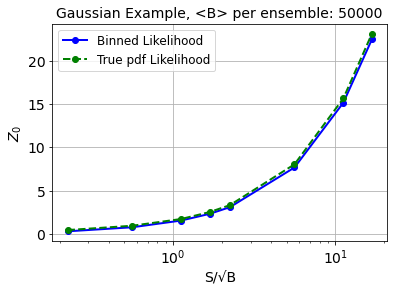

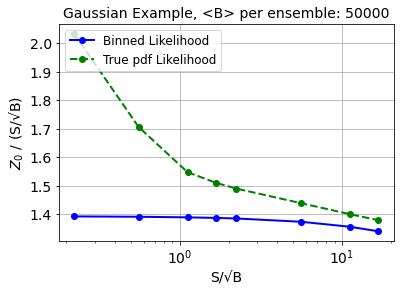

In [12]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label='mu_hat')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.show()






plt.figure()
lw = 2

plt.plot(posX, store_Z_bins, '-ok', color='blue', lw=lw, label='Binned Likelihood') 
plt.plot(posX, store_Z_gaussian, '--ok', color='green', lw=lw, label=r'True pdf Likelihood')

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{0}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()




# Normalized

plt.figure()
lw = 2

store_Z_bins_norm = [ a/b for a, b in zip(store_Z_bins,posX)]
store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,posX)]

plt.plot(posX, store_Z_bins_norm, '-ok', color='blue', lw=lw, label='Binned Likelihood') 
plt.plot(posX, store_Z_gaussian_norm, '--ok', color='green', lw=lw, label=r'True pdf Likelihood')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 8])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{0}$ / (S/√B)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### 3. MACHINE-LEARNED LIKELIHOOD

B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
n_ensembles (initial):  10000

 If  10010  =  1005    then the proposed range has to be extended
n_ensembles (actual):  9232

 This may take long... 



<ipython-input-15-d2977ee7b5aa>:157: RuntimeWarning: invalid value encountered in log
  q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


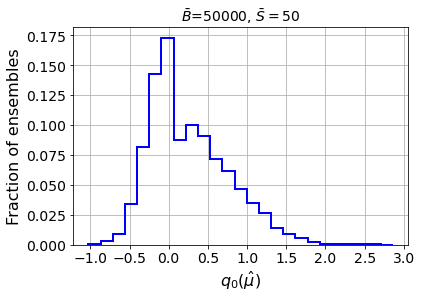

muhat mean:  0.8372941941074523
median q_muhat:  0.14399432727908845
Z_XG:  0.3794658446805041

 ----------------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
n_ensembles (initial):  10000

 If  10025  =  1006    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



<ipython-input-15-d2977ee7b5aa>:157: RuntimeWarning: invalid value encountered in log
  q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


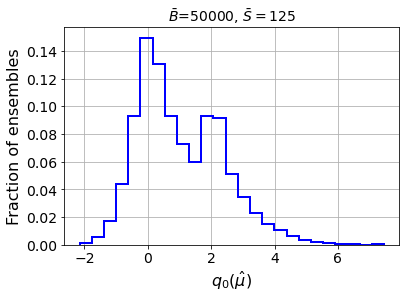

muhat mean:  0.9421531463229719
median q_muhat:  0.7657188667707544
Z_XG:  0.875053636510788

 ----------------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
n_ensembles (initial):  10000

 If  10050  =  1007    then the proposed range has to be extended
n_ensembles (actual):  9234

 This may take long... 



<ipython-input-15-d2977ee7b5aa>:157: RuntimeWarning: invalid value encountered in log
  q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


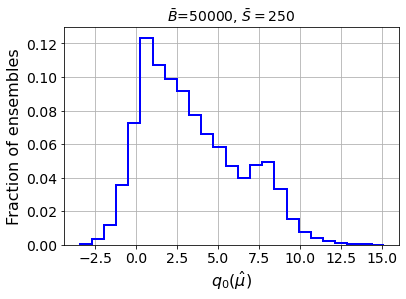

muhat mean:  1.0489170457006713
median q_muhat:  2.8405013848094427
Z_XG:  1.6853787066441306

 ----------------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
n_ensembles (initial):  10000

 If  10075  =  1007    then the proposed range has to be extended
n_ensembles (actual):  9234

 This may take long... 



<ipython-input-15-d2977ee7b5aa>:157: RuntimeWarning: invalid value encountered in log
  q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


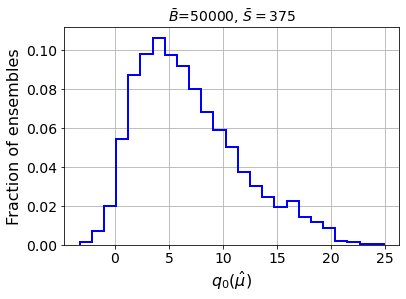

muhat mean:  1.069114143383149
median q_muhat:  6.044485875192095
Z_XG:  2.4585536144636126

 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



<ipython-input-15-d2977ee7b5aa>:157: RuntimeWarning: invalid value encountered in log
  q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


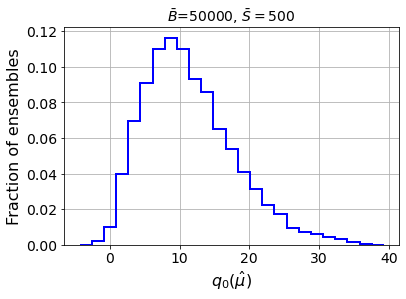

muhat mean:  1.0653742012347014
median q_muhat:  10.504761616686437
Z_XG:  3.241104999330697

 ----------------------------------------- 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
n_ensembles (initial):  10000

 If  10250  =  1015    then the proposed range has to be extended
n_ensembles (actual):  9242

 This may take long... 



<ipython-input-15-d2977ee7b5aa>:157: RuntimeWarning: invalid value encountered in log
  q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


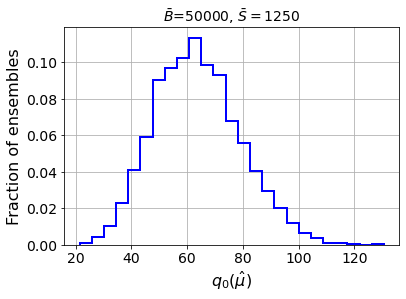

muhat mean:  1.0538519800908892
median q_muhat:  62.72436894873317
Z_XG:  7.919871776028522

 ----------------------------------------- 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
n_ensembles (initial):  10000

 If  10500  =  1025    then the proposed range has to be extended
n_ensembles (actual):  9238

 This may take long... 



<ipython-input-15-d2977ee7b5aa>:157: RuntimeWarning: invalid value encountered in log
  q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


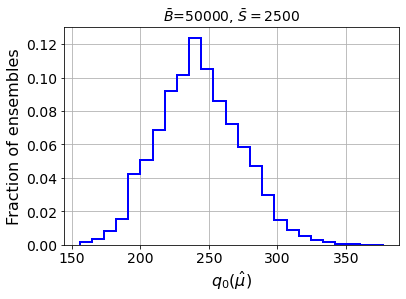

muhat mean:  1.0510283611171247
median q_muhat:  241.60453929489995
Z_XG:  15.543633400685309

 ----------------------------------------- 

B_expected:  50000
S_expected:  3750
S/$\sqrt{B}$:  16.77050983124842
n_ensembles (initial):  10000

 If  10750  =  1034    then the proposed range has to be extended
n_ensembles (actual):  9234

 This may take long... 



<ipython-input-15-d2977ee7b5aa>:157: RuntimeWarning: invalid value encountered in log
  q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


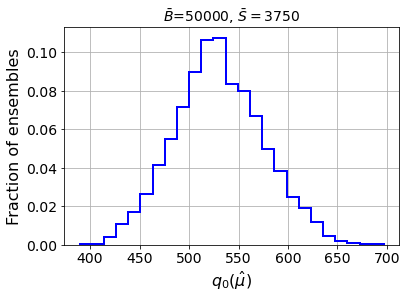

muhat mean:  1.0500866363439463
median q_muhat:  528.4793883590032
Z_XG:  22.988679569714378

 ----------------------------------------- 



In [15]:
store_muhat_mean_XG_MLL = []
store_Z_XG_MLL = []


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        

for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')


    # NOW LETS APPLY THE METHOD

    muhat_selected_list = []
    q_muhat = []

    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

            # SIGNAL: classification score for the SIGNAL events in an ensemble
            pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

            # BACKGROUND: classification score for the BACKGROUND events in an ensemble
            pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])


           
        
            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )
            
            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )
            
            
            

            
            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble



            mu_hat_condition_equal_1 = []

            # grid, mu_hat is around 1
            muhat_test = np.arange(0.5, 2, 0.1).tolist()

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



            muhat_selected = 1

            # from the grid, select the mu_hat such that the condition is equal to 1
            if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 > 0:
                        muhat_selected = muhat_test[ll]
                        break


            if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 < 0:
                        muhat_selected = muhat_test[ll]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



    # Histogram of q_muhats

    weights = np.ones_like(q_muhat)/float(len(q_muhat))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


   
    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean = np.mean(muhat_selected_list)
    store_muhat_mean_XG_MLL.append(muhat_mean)

    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]
    
    q_muhat_median = np.median(q_muhat)

    Z_XG = abs(q_muhat_median)**0.5
    store_Z_XG_MLL.append(Z_XG)

    print('muhat mean: ', muhat_mean)
    print('median q_muhat: ', q_muhat_median)
    print('Z_XG: ', Z_XG)

    
    print('\n ----------------------------------------- \n')
    

In [16]:
print(store_muhat_mean_XG_MLL)
print(store_Z_XG_MLL)

[0.8372941941074523, 0.9421531463229719, 1.0489170457006713, 1.069114143383149, 1.0653742012347014, 1.0538519800908892, 1.0510283611171247, 1.0500866363439463]
[0.3794658446805041, 0.875053636510788, 1.6853787066441306, 2.4585536144636126, 3.241104999330697, 7.919871776028522, 15.543633400685309, 22.988679569714378]


In [13]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_XG_MLL = [0.8372941941074523, 0.9421531463229719, 1.0489170457006713, 1.069114143383149, 1.0653742012347014, 1.0538519800908892, 1.0510283611171247, 1.0500866363439463]
store_Z_XG_MLL = [0.3794658446805041, 0.875053636510788, 1.6853787066441306, 2.4585536144636126, 3.241104999330697, 7.919871776028522, 15.543633400685309, 22.988679569714378]

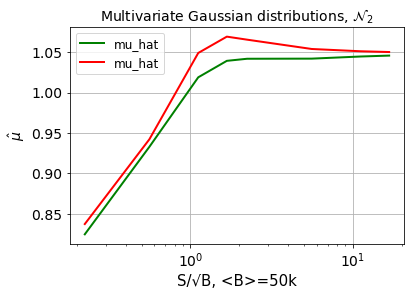

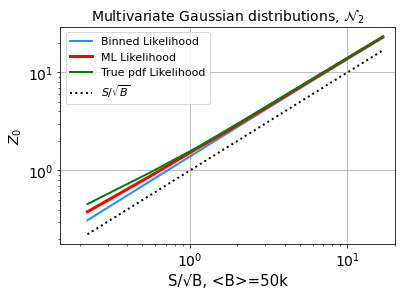

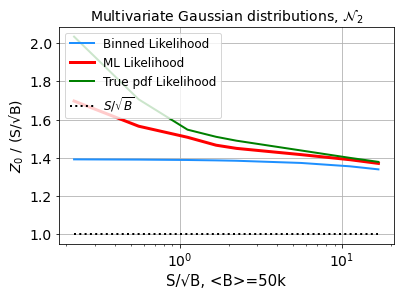

In [19]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_gaussian, '-', color='green', lw=lw, label='mu_hat')
plt.plot(posX, store_muhat_mean_XG_MLL, '-', color='red', lw=lw, label='mu_hat')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B, <B>=50k', fontsize=15)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()





plt.figure()
lw = 2

plt.plot(posX, store_Z_bins, '-', color='dodgerblue', lw=lw, label='Binned Likelihood') 
plt.plot(posX, store_Z_XG_MLL, '-', color='red', lw=3, label=r'ML Likelihood')
plt.plot(posX, store_Z_gaussian, '-', color='green', lw=lw, label=r'True pdf Likelihood')
#plt.plot(posX, SrootB_WP2, '--', color='darkorange', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[2] )
#plt.plot(posX, SrootB_WP1, '--', color='magenta', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[1] )
#plt.plot(posX, SrootB_WP0, '--', color='navy', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[0] )
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

plt.xlim([0.15, 20])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S/√B, <B>=50k', fontsize=15)
plt.ylabel('$Z_{0}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.legend(loc="upper left", fontsize=11)
#plt.savefig('images/' + '2gaussian-Z-example-log.pdf', format="pdf", bbox_inches="tight")
plt.show()







# Normalized

plt.figure()
lw = 2

store_Z_bins_norm = [ a/b for a, b in zip(store_Z_bins,posX)]
store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,posX)]
store_Z_XG_MLL_norm = [ a/b for a, b in zip(store_Z_XG_MLL,posX)]
posX_norm = [ a/b for a, b in zip(posX,posX)]


plt.plot(posX, store_Z_bins_norm, '-', color='dodgerblue', lw=lw, label='Binned Likelihood') 
plt.plot(posX, store_Z_XG_MLL_norm, '-', color='red', lw=3, label=r'ML Likelihood')
plt.plot(posX, store_Z_gaussian_norm, '-', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, posX_norm, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 8])
plt.xscale('log')
plt.xlabel('S/√B, <B>=50k', fontsize=15)
plt.ylabel('$Z_{0}$ / (S/√B)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

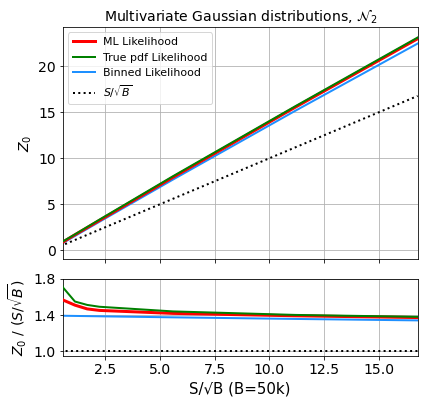

In [20]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(posX, store_Z_XG_MLL, '-', color='red', lw=3, label=r'ML Likelihood', zorder=5)
axs[0].plot(posX, store_Z_gaussian, '-', color='green', lw=lw, label=r'True pdf Likelihood', zorder=5)
axs[0].plot(posX, store_Z_bins, '-', color='dodgerblue', lw=lw, label='Binned Likelihood') 
axs[0].plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')


store_Z_bins_norm = [ a/b for a, b in zip(store_Z_bins,posX)]
store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,posX)]
store_Z_XG_MLL_norm = [ a/b for a, b in zip(store_Z_XG_MLL,posX)]
SrootB_WP2_norm = [ a/b for a, b in zip(SrootB_WP2,posX)]
SrootB_WP1_norm = [ a/b for a, b in zip(SrootB_WP1,posX)]
SrootB_WP0_norm = [ a/b for a, b in zip(SrootB_WP0,posX)]
posX_norm = [ a/b for a, b in zip(posX,posX)]


axs[1].plot(posX, store_Z_bins_norm, '-', color='dodgerblue', lw=lw, label='Binned Likelihood') 
axs[1].plot(posX, store_Z_XG_MLL_norm, '-', color='red', lw=3, label=r'ML Likelihood', zorder=5)
axs[1].plot(posX, store_Z_gaussian_norm, '-', color='green', lw=lw, label=r'True pdf Likelihood', zorder=5)
axs[1].plot(posX, posX_norm, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')



axs[0].set_xlim([posX[1], posX[-1]])
axs[1].set_xlim([posX[1], posX[-1]])
axs[1].set_ylim([0.95,1.8])
axs[0].set_ylabel('$Z_{0}$', fontsize=14)
axs[1].set_xlabel('S/√B (B=50k)', fontsize=15)
axs[1].set_ylabel('$Z_{0}$ / ($S/\sqrt{B}$)', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([1,1.4,1.8])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
axs[0].legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-example.pdf', format="pdf", bbox_inches="tight")
plt.show()